# Homeworks - Big Data and Public Policy Class

The objective of the following homework is to **bring to practice the tools studied in class** by conducting step by step a first big data project. We advise that you do it in parallel with the lectures: the relation between the project steps and the lectures is indicated below. 

You will build several **machine learning models that will predict continuous and categorical variables based on data coming from webscraping and/or an API**. 

We propose that you predict the **daily stock price data of a large company** (of your choice) **based on the company's tweets**. You can chose a company from one of the [major stock indices](https://www.wikiwand.com/en/List_of_stock_market_indices).

**Felix' Idea:**
- predict stock prices of selected U.S. - based companies based on the companies tweets and COVID-19 data from JHU CSSE.
- Companies:
    - **3M**: "Best known as the maker of Scotch tape and Post-It notes, 3M (MMM) also happens to be one of the largest producers of N95 respirators, the type of mask that more efficiently protects people against the virus than ordinary medical masks. Coronavirus has caused a worldwide mask shortage. N95 respirators and regular surgical masks have been unavailable on all major e-commerce platforms in the United States and China since early this year.
This would not be the first time that 3M benefited from a global health crisis. When the SARS epidemic hit in 2003, 3M's sales growth shot up amid increased demand for its respirators, according to the Melius report.
"The 2002 impact from SARS was highly beneficial to 3M," said Scott Davis, a co-author of the report, told CNN Business. While the company didn't disclose any specifics at the time, "it was meaningful and helped the stock to outperform in that period."
Basic medical masks provide a barrier from particulate matter, but do not seal tightly enough against the wearer's face to eliminate the risk of contracting the virus. Worn properly, the N95 mask can filter out about 95% of small airborne particles, according to Christiana Coyle, an expert in epidemics at New York University."
([See article](https://edition.cnn.com/2020/02/27/business/3m-coronavirus-hedge/index.html)).
    - **ABI.BR** - Anheuser Busch Inbev NV: the mother-company that owns the Corona beer brand
    
In cell number 5 of this notebook, you can specify a tuple of twitter account name and yahoo finance ticker id for any stock-listed company you would like. I included pre-downloaded tweet data for 3M and ABI as well as county-level COVID-19 data for the U.S.

In [1]:
# Imports
import os
import re
import ast
import time
import requests

import numpy as np
import pandas as pd
import xarray as xr
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
import tweepy
from tweepy import OAuthHandler
from bs4 import BeautifulSoup
from IPython.display import display
from pprint import pprint

from scipy.stats import kendalltau, pearsonr, spearmanr
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix, accuracy_score, roc_curve, 
                             auc, roc_auc_score)

In [2]:
# Display options
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50

# plotting options
sns.set(style="white")

# global objects
sid = SentimentIntensityAnalyzer()

### Class and function definitions

In [3]:
def fetch_tweets(account, n_tweets = 5000):
    """Fetch data from twitter account"""
    df_out = pd.DataFrame()
    
    try:   
        # Put the tweets into a data frame object
        tweet_count = 0
        for tweet in tweepy.Cursor(api.user_timeline, 
                                   screen_name=account,
                                   tweet_mode='extended').items(n_tweets):
    
                    # 1. Transform the json into a dataframe
                    df_tweet = pd.DataFrame.from_dict(tweet._json, orient='index', 
                                                      columns=[tweet_count]) # , sleep_on_rate_limit=True
    
                    # 2. adds screen name as a row
                    #df_tweet=df_tweet.append(pd.DataFrame({tweet_count:[target]}, index=['twitter_handle']))
    
                    # 3. Concatenate the tweet dataframe to the df_tweets dataframe
                    df_out = pd.concat([df_tweet, df_out], axis=1)
    
                    # count the number of tweets fetched
                    tweet_count += 1 
    
        time.sleep(1)
    
    # except if TweepError arises
    except tweepy.TweepError: #the error arises when the user has protected tweets
        print("Failed to run the command "
              "on user {}, Skipping...".format(account))
    
    # except if RateLimitError arises
    except tweepy.RateLimitError:
        print("resource usage limit: {} skipped".format(account))
        time.sleep(15 * 60) # wait 15 mins
    
    # transpose
    df_out = df_out.transpose()
    
    # try auto-inferring dtypes to cast columns from dtype "object" to more 
    # appropriate and memory-efficient dtypes
    df_out = df_out.infer_objects()
    
    # manually deal with the remaining column dtypes
    df_out['created_at'] = pd.to_datetime(df_out['created_at'])
    
    # set datetime index
    df_out = df_out.set_index('created_at')
    return df_out


def occurrence_counter(string_list, search_string):
    """counts occurence of word(s) in string"""
    return sum(map(lambda x: x in string_list, search_string.split(' ')))


def read_data(infile, parse_col, date_str='%Y-%m-%d', sep=','):
    """
    Function to read data.

    Parameters
    ----------
    infile : str
        Path to data.
    parse_col : str
        Column name of time variable.
    date_str : str
        String for datetime conversion.

    returns
    -------
    data : pd.DataFrame
    """
    def dateparse(x): return pd.datetime.strptime(x, date_str)
    data = pd.read_csv(infile, sep=sep, 
                       parse_dates=[parse_col], date_parser=dateparse)
    data.index = data[parse_col]
    data = data.drop(labels=parse_col, axis=1)
    return data


def fetch_stock_data(ticker, start, end, period="1d", save=True):
    """fetch stock market data via yahoo finance api"""
    stock_data = yf.download(tickers=ticker, 
                             # start coincides with start of 3M twitter account
                             start=start, 
                             end=end, 
                             period=period)
    if save: 
        stock_data.to_csv('data/{}_yfinance_{}_{}.csv'.format(
            ticker, start, end), sep=';')
        return stock_data
    else:
        return stock_data
    

def correlation_matrix(df):
    """
    Given a pd.DataFrame, calculate Pearson's R
    and the p-values of the correlation.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe containing numeric values.
    Returns
    -------
    (correlations, p_values) : tuple
        Tuple of dataframes.
    """
    df = df.dropna()._get_numeric_data()
    cols = pd.DataFrame(columns=df.columns)

    correlations = cols.transpose().join(cols, how='outer')
    p_values = cols.transpose().join(cols, how='outer')

    for r in df.columns:
        for c in df.columns:
            # pearsonr returns a tuple like (corr, pval)
            correlations[r][c] = round(pearsonr(df[r], df[c])[0], 4)
            p_values[r][c] = round(pearsonr(df[r], df[c])[1], 4)

    return (correlations.apply(pd.to_numeric),
            p_values.apply(pd.to_numeric))


def correlation_matrix_plot(df, significance_level=0.05, cbar_levels=8,
                            figsize=(6,6)):
    """Plot corrmat considering p-vals."""
    corr, pvals = correlation_matrix(df)

    # create triangular mask for heatmap
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    # mask corrs based on p-values
    pvals_plot = np.where(pvals > significance_level, np.nan, corr)

    # plot
    # -------------------------------------------------------------------------
    # define correct cbar height and pass to sns.heatmap function
    fig, ax = plt.subplots(figsize=figsize)
    cbar_kws = {"fraction": 0.046, "pad": 0.04}
    sns.heatmap(corr,
                mask=mask,
                cmap=sns.diverging_palette(20, 220, n=cbar_levels),
                square=True,
                vmin=-1,
                center=0,
                vmax=1,
                annot=pvals_plot,
                cbar_kws=cbar_kws)
    plt.title("p < {:.2f}".format(significance_level))
    plt.tight_layout()
    return fig, ax


def compute_sentiments(text, all_scores=True):
    """
    Compute sentiment score for text. Can be applied to pd.DataFrame
    via .apply()

    Parameters
    ----------
    text : str
        Text snippet.

    all_scores : bool
        If False, return compound sentiment score only. If True, return dict
        with all four sentiment scores.

    Returns
    -------
    Sentiment scores as tuple of ('neg', 'neu', 'pos', 'compound')
    """
    sentiments = sid.polarity_scores(text)
    sentiment_scores = tuple(sentiments.values())

    if all_scores:
        return sentiment_scores
    else:
        return sentiment_scores[3]

Twitter API: please use your own credentials.

In [4]:
# Credentials
api_key = "" # API key
api_key_secret = "" # API secret key
access_token = ""
access_token_secret = ""

# Authentification
auth = OAuthHandler(api_key, api_key_secret) #creating an OAuthHandler instance
auth.set_access_token(access_token, access_token_secret) # set tokens
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)# create api connection

# test authentication
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


---------------------------
After having decided the setting (your own or the company + corresponding timespan) that you will study, you should follow the following steps:

**Step 1a: `X` variables** [week 2]
- Fetch the data using the **twitter API** or any other API or website that you are interested in.
- Beware of the rate limits and organize your program so as to overcome them if needed
- The data should include some text, but might also have other interesting variables (retweets, favorites...)
- Create some (non-text based) `X_num` variables that you will use for the prediction

Specify the **ticker name** (`target_ticker`) of stock-market listed company likely affected by the COVID-19 pandemic and it's corresponding **twitter account name** (`target_account`). 

In [5]:
target_account, target_ticker = ("3M", "MMM")
#target_account, target_ticker = ("corona", "ABI.BR")

In [6]:
# read tweet data
file = "data/{}_tweets_{}.csv".format(target_account, "2020-05-31")

if os.path.exists(file):
    print("file exists. reading.")
    df_tweets = pd.read_csv(file, sep=',', index_col='created_at')
    df_tweets.index = pd.to_datetime(df_tweets.index)
else:
    print("file does not exist. fetching tweets from scratch.")
    df_tweets = fetch_tweets(target_account)
    df_tweets.to_csv(file)

file exists. reading.


In [7]:
# read CSSE data
csse = xr.open_dataset("data/csse_data_merged.nc", engine='netcdf4')
csse_us = csse.sum(dim='county').to_dataframe()

csse_us['confirmed_d1'] = np.gradient(csse_us['confirmed'].values)
csse_us['deaths_d1'] = np.gradient(csse_us['deaths'].values)

csse_us['confirmed_d2'] = np.gradient(csse_us['confirmed_d1'].values)
csse_us['deaths_d2'] = np.gradient(csse_us['deaths_d1'].values)
csse_us

,confirmed,deaths,confirmed_d1,deaths_d1,confirmed_d2,deaths_d2
time,,,,,,
2020-01-22,1,0,0.0,0.0,0.50,0.00
2020-01-23,1,0,0.5,0.0,0.25,0.00
2020-01-24,2,0,0.5,0.0,0.50,0.00
2020-01-25,2,0,1.5,0.0,0.50,0.00
2020-01-26,5,0,1.5,0.0,-0.75,0.00
...,...,...,...,...,...,...
2020-05-26,1675579,98808,18280.5,1101.0,720.75,377.50
2020-05-27,1693570,100317,20227.0,1350.5,2483.00,45.50
2020-05-28,1716033,101509,23246.5,1192.0,1860.50,-136.75


## Create numeric X variable(s) based on fetched tweets

### Counts of certain covid-related keywords

n_text        22
n_hashtags    13
n_total       35
dtype: int64

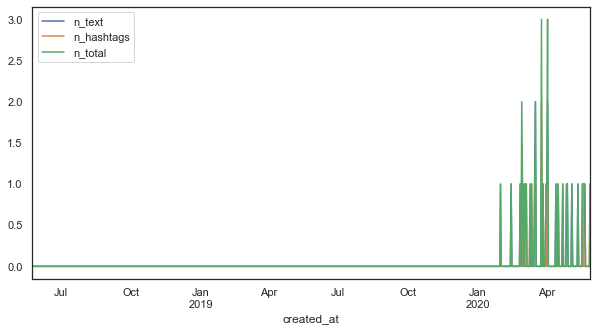

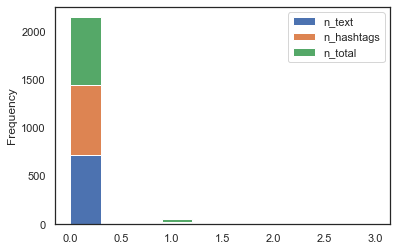

In [8]:
# empty X_num df
X_num = pd.DataFrame(index=df_tweets.index, columns=['n_text', 'n_hashtags'])

# define list of search strings
keywords = ['coronavirus', 'covid19', 'covid', 'virus', 'covid-19', 'COVID-19', 'COVID' 'corona']
hashtag_search_strings = keywords
text_search_strings = keywords

# counter 
idx_num = 0

for idx, row in df_tweets.iterrows():
    # 1) infer number of times the search strings were mentioned as a hashtag
    # -------------------------------------------------------------------------
    # parse string representation of dict to dict using ast module
    if isinstance(row['entities'], dict):
        hashtags_list_of_dicts = row['entities']['hashtags']
    else:
        hashtags_list_of_dicts = ast.literal_eval(row['entities']).get('hashtags')
    if len(hashtags_list_of_dicts) != 0:
        hashtags = []
        for hashtag_entry in hashtags_list_of_dicts:
            hashtags.append(hashtag_entry.get('text'))
        
        # count ocurrences of words defined in search_strings
        hashtag_counts = []
        for keyword in hashtag_search_strings:
            hashtag_counts.append(occurrence_counter(string_list=hashtags, 
                                                     search_string=keyword))
        # append count
        X_num.iloc[idx_num]['n_hashtags'] = sum(hashtag_counts)
    else:
        X_num.iloc[idx_num]['n_hashtags'] = 0
        
    # 2) infer number of times the search strings were mentioned in tweet text
    # -------------------------------------------------------------------------
    full_text = row['full_text'].split()
    
    # count ocurrences of words defined in search_strings
    text_counts = []
    for keyword in text_search_strings:
            text_counts.append(occurrence_counter(string_list=full_text, 
                                                  search_string=keyword))
    # append count
    if sum(text_counts) != 0:
        X_num.iloc[idx_num]['n_text'] = sum(text_counts)
    else:
        X_num.iloc[idx_num]['n_text'] = 0
    # end of loop: update counter
    idx_num += 1


# combine text and hashtag ocurrences in additional column
X_num['n_total'] = X_num['n_text'] + X_num['n_hashtags']
X_num_daily = X_num.resample('D').sum()
X_num_daily.plot(figsize=(10,5))
X_num_daily.plot.hist(stacked=True)
X_num_daily.describe()

X_num_daily.sum(axis=0)

As you can see, I played around with word occurences as potential covariates. However, for the Regression and Classification tasks I stuck with the sentiment and CSSE data.

**Step 3: text analysis** [week 4]
- Featurize tweets (or another text dataset related to your subject): transform the text into a standard document-level dataset `X_doc`

In [9]:
sentiment_scores = df_tweets['full_text'].apply(compute_sentiments)

sentiment_data = {}
col_names = ['neg', 'neu', 'pos', 'compound']
sentiment_colname = 'sentiments'
        
df_sentiments = pd.DataFrame(data=sentiment_scores.values,
                                         columns=[sentiment_colname],
                                         index=df_tweets.index)

# tuple to multiple columns
for n, col in enumerate(col_names):
    df_sentiments[col] = df_sentiments[sentiment_colname].apply(
        lambda sentiments: sentiments[n])

sentiment_data = df_sentiments.drop(sentiment_colname, axis=1)

In [10]:
# resample
X_num_daily = sentiment_data.resample('D').mean()

# smooth with 3-day windowed moving average to reduce noise
X_num_daily = X_num_daily.rolling(window="3d", center=False).mean()

# localize tz of csse df
try:
    csse_us.index = csse_us.index.tz_localize('UTC')
except TypeError as e:
    print(e)
    pass

# merge in csse data
X_num_daily = pd.merge(X_num_daily, csse_us, left_index=True, right_index=True)

**Step 1b: continuous `y` variables** [week 2]
- Fetching the data: 
    - if you work on the suggested idea, you can easily access daily stock 
    prices using the [`yfinance` package](https://pypi.org/project/yfinance/) (see below)
    - otherwise, you can find some interesting data listed in the syllabus

In [11]:
# fetch 3M data
file_ticker = "data/{}_yfinance_2018-01-01_{}.csv".format(target_ticker, "2020-05-31")
if os.path.exists(file_ticker):
     # read existing data
    stock_data = read_data(infile=file_ticker, parse_col="Date", sep=';')
else:
    # fetch from scratch
    stock_data = fetch_stock_data(ticker=target_ticker, 
                              start= "2018-01-01", 
                              end="{}".format("2020-05-31"),
                              save=True)

/Users/felix/miniconda3/envs/bd4pp/lib/python3.7/site-packages/ipykernel_launcher.py:74: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


**Step 1c: merge `X_num` and `y`** [week 2]
- Beware of the temporality: in the case of the proposed study on stock market prices, you will have to deal with the fact that the X is at the tweet level while `y` is daily.

In [12]:
try:
    stock_data.index = stock_data.index.tz_localize('UTC')
except TypeError as e:
    print(e)
    pass

#stock_data.index = stock_data.index.tz_convert(None)
df_merged = pd.merge(X_num_daily, stock_data, left_index=True, right_index=True)

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x124d51d10>)

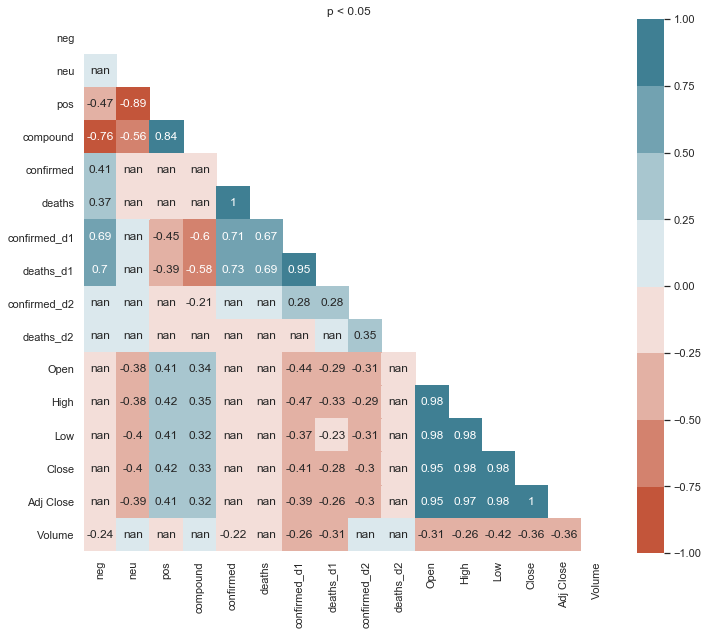

In [13]:
correlation_matrix_plot(df=df_merged, figsize=(10,10))

There are significant (at p < 0.05) correlations between the variable of interest `Adj Close`, the closing price of the stock for a given day, and sentiment scores as well as number of covid19 related deaths/infections and their time-derivatives. This is a positive sign, as it means that we can likely exploit these correlations to obtain meaningful predictions.

**Sample split.** Do the standard 80% / 20% training/test split using all days in the data. In addition, do a separate temporal split where the training set is the first 80% of days in the time series.

**For all machine learning models**, report performance measure in test and train samples.

**Note from Felix:** I decided to only do a 5-fold Time series cross validation and report the mean validation metrics. These results are much less sensitive to the way the split is chosen.

In [14]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

def ts_crossval(model, n_folds=5, plot=False):
    """Performs time series CV on any sklearn regression model"""
    
    tscv = TimeSeriesSplit(n_splits=n_folds)
    
    # store metrics for each fold
    crossval = {"R2_is": [],
                "R2_oos": [],
                "RMSE_is": [],
                "RMSE_oos": []}

    i = 1
    for train_index, test_index in tscv.split(X):

        # split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # in-sample performance
        # ------------------------------------------------------------
        model_is = model.fit(X_train, y_train)
        y_train_pred = model_is.predict(X_train)

        # R^2, MSE and RMSE
        r2_is = r2_score(y_train, y_train_pred)
        mse_is = mean_squared_error(y_train, y_train_pred)
        rmse_is = np.sqrt(mse_is)

        # append to crossval dict
        crossval["R2_is"].append(r2_is)
        crossval["RMSE_is"].append(rmse_is)

        # out-of-sample performance
        # ------------------------------------------------------------
        model_oos = model.fit(X_test, y_test)
        y_test_pred = model_oos.predict(X_test)   

        # R^2, MSE and RMSE
        r2_oos = r2_score(y_test, y_test_pred)
        mse_oos = mean_squared_error(y_test, y_test_pred)
        rmse_oos = np.sqrt(mse_oos)

        # append to crossval dict
        crossval["R2_oos"].append(r2_oos)
        crossval["RMSE_oos"].append(rmse_oos)

        # Regplot (optional)
        # ------------------------------------------------------------
        if plot:
            g=sns.regplot(x=y_test_pred, y=y_test, x_bins=100)
            g=g.set_title("Fold {}".format(i))
            plt.annotate('In-sample R2={:.2f}'.format(r2_is),
                        xy=(1, 0.05),  xycoords='axes fraction',
                        horizontalalignment='right',
                        verticalalignment='bottom')
            plt.annotate('Out-of-sample R2={:.2f}'.format(r2_oos),
                        xy=(1, 0),  xycoords='axes fraction',
                        horizontalalignment='right',
                        verticalalignment='bottom')
            plt.xlabel("Adj Close Predicted ($)")
            plt.ylabel("Adj Close ($)")
            plt.axis('tight')
            plt.tight_layout()
            plt.show(g)
        
        # update counter
        i+=1

    # store metrics in data frame
    df_crossval = pd.DataFrame.from_dict(crossval)
    print("Mean metrics from {} folds".format(n_folds))
    print(df_crossval.mean(axis=0))
    print("")
    

def ts_crossval_classification(model, n_folds=5):
    """Performs time series CV on any sklearn classification model"""
    
    tscv = TimeSeriesSplit(n_splits=n_folds)
    
    # store metrics for each fold
    crossval = {"precision_is": [],
                "precision_oos": [],
                "recall_is": [],
                "recall_oos": [],
                "f1_is": [],
                "f1_oos": [],
                "accuracy_is": [],
                "accuracy_oos": [],
                "auc_is": [],
                "auc_oos": [],
               }

    i = 1
    for train_index, test_index in tscv.split(X):

        # split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # in-sample performance
        # ------------------------------------------------------------
        # Fit
        model_is = model.fit(X_train, y_train)
        y_train_pred = model_is.predict(X_train)
        
        # validation metrics for classification problems
        crossval["precision_is"].append(precision_score(y_train, y_train_pred))
        crossval["recall_is"].append(recall_score(y_train, y_train_pred))
        crossval["f1_is"].append(f1_score(y_train, y_train_pred))
        crossval["accuracy_is"].append(accuracy_score(y_train, y_train_pred))
        crossval["auc_is"].append(roc_auc_score(y_train, y_train_pred))

        # out-of-sample performance
        # ------------------------------------------------------------
        model_oos = model.fit(X_test, y_test)
        y_test_pred = model_oos.predict(X_test)   

        # validation metrics for classification problems
        crossval["precision_oos"].append(precision_score(y_test, y_test_pred))
        crossval["recall_oos"].append(recall_score(y_test, y_test_pred))
        crossval["f1_oos"].append(f1_score(y_test, y_test_pred))
        crossval["accuracy_oos"].append(accuracy_score(y_test, y_test_pred))
        crossval["auc_oos"].append(roc_auc_score(y_test, y_test_pred))

        # update counter
        i+=1

    # store metrics in data frame
    df_crossval = pd.DataFrame.from_dict(crossval)
    #print("Mean metrics from {} folds".format(n_folds))
    f, ax = plt.subplots()
    ax = df_crossval.mean(axis=0).plot.bar()
    ax.set_ylim(0,1)
    ax.set_title(str(type(model)))
    print("")

**Step 2a: estimate different regression models using `X_num` and `y`** [week 3]
***Milestone 2 - March 31th***  *You can submit the previous steps as a second notebook.*

In [15]:
import warnings
warnings.filterwarnings('ignore')

# numeric covariates
sample = df_merged[['Adj Close', 'confirmed', 'deaths', 'confirmed_d1', 'deaths_d1', 'confirmed_d2', 'deaths_d2']]
sample_dropna = sample.dropna(axis=0)

X_num = sample_dropna[['confirmed', 'deaths', 'confirmed_d1', 'deaths_d1', 'confirmed_d2', 'deaths_d2']]
X = X_num.values

# y 
y_full = sample_dropna['Adj Close']
y = y_full.values

print("Sample size of data set: {}\n".format(len(y)))
# -----------------------------------------------------------------

# 1) Linear regression
lin_reg = LinearRegression()
print("Linear regression")
ts_crossval(lin_reg)

# 2) Ridge regression
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=2, solver='cholesky', random_state=42) 
print("Ridge regression")
ts_crossval(ridge_reg)

# 3) Lasso regression
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=1, random_state=42)
print("Lasso regression")
ts_crossval(lasso_reg)

# 4) Elastic Net
from sklearn.linear_model import ElasticNet
elanet_reg = ElasticNet(random_state=42)
print("Elastic Net regression")
ts_crossval(elanet_reg)

# 5) Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=42)
print("Random forest regression")
ts_crossval(rf_reg)

Sample size of data set: 89

Linear regression
Mean metrics from 5 folds
R2_is       0.515113
R2_oos      0.583989
RMSE_is     7.287483
RMSE_oos    3.614673
dtype: float64

Ridge regression
Mean metrics from 5 folds
R2_is       0.503269
R2_oos      0.572184
RMSE_is     7.350472
RMSE_oos    3.647749
dtype: float64

Lasso regression
Mean metrics from 5 folds
R2_is       0.461361
R2_oos      0.524751
RMSE_is     7.591854
RMSE_oos    3.779368
dtype: float64

Elastic Net regression
Mean metrics from 5 folds
R2_is       0.469361
R2_oos      0.529482
RMSE_is     7.550811
RMSE_oos    3.766765
dtype: float64

Random forest regression
Mean metrics from 5 folds
R2_is       0.962081
R2_oos      0.889520
RMSE_is     1.850713
RMSE_oos    1.852621
dtype: float64



The untuned random forest model by far outperforms the other models based on the X_num covariates.

**Step 2b: estimate different regression models using `X_doc` and `y`** [week 3]

In [16]:
import warnings
warnings.filterwarnings('ignore')

# text-based covariates: 
# note that corona does not post a lot of tweets, so I needed to drop the missing values.
# the obtained results are not robust at all due to the small sample size. 
sample = df_merged[['Adj Close', 'neg', 'neu', 'pos', 'compound']]
sample_dropna = sample.dropna(axis=0)

X_num = sample_dropna[['neg', 'neu', 'pos', 'compound']]
X = X_num.values

# y 
y_full = sample_dropna['Adj Close']
y = y_full.values

print("Sample size of data set: {}\n".format(len(y)))
# -----------------------------------------------------------------

# 1) Linear regression
lin_reg = LinearRegression()
print("Linear regression")
ts_crossval(lin_reg)

# 2) Ridge regression
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=2, solver='cholesky', random_state=42) 
print("Ridge regression")
ts_crossval(ridge_reg)

# 3) Lasso regression
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=1, random_state=42)
print("Lasso regression")
ts_crossval(lasso_reg)

# 4) Elastic Net
from sklearn.linear_model import ElasticNet
elanet_reg = ElasticNet(random_state=42)
print("Elastic Net regression")
ts_crossval(elanet_reg)

# 5) Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=42)
print("Random forest regression")
ts_crossval(rf_reg)

Sample size of data set: 89

Linear regression
Mean metrics from 5 folds
R2_is       0.264121
R2_oos      0.619538
RMSE_is     8.980906
RMSE_oos    3.528709
dtype: float64

Ridge regression
Mean metrics from 5 folds
R2_is       0.074784
R2_oos      0.066081
RMSE_is     9.984235
RMSE_oos    5.721585
dtype: float64

Lasso regression
Mean metrics from 5 folds
R2_is        0.000000
R2_oos       0.000000
RMSE_is     10.449398
RMSE_oos     5.955658
dtype: float64

Elastic Net regression
Mean metrics from 5 folds
R2_is        0.003476
R2_oos       0.007415
RMSE_is     10.427897
RMSE_oos     5.928181
dtype: float64

Random forest regression
Mean metrics from 5 folds
R2_is       0.862471
R2_oos      0.859164
RMSE_is     3.751475
RMSE_oos    2.165029
dtype: float64



Again, the untuned random forest model by far outperforms the other models, here based on the X_doc covariates.

**Bonus:** both X_doc and X_num as covariates

In [17]:
import warnings
warnings.filterwarnings('ignore')

# using all covariates
sample = df_merged
sample_dropna = sample.dropna(axis=0)

X_num = sample_dropna[['neg', 'neu', 'pos', 'compound', 'confirmed', 'deaths', 
                       'confirmed_d1', 'deaths_d1', 'confirmed_d2', 'deaths_d2']]
X = X_num.values

# y 
y_full = sample_dropna['Adj Close']
y = y_full.values

print("Sample size of data set: {}\n".format(len(y)))
# -----------------------------------------------------------------

# 1) Linear regression
lin_reg = LinearRegression()
print("Linear regression")
ts_crossval(lin_reg)

# 2) Ridge regression
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=2, solver='cholesky', random_state=42) 
print("Ridge regression")
ts_crossval(ridge_reg)

# 3) Lasso regression
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=1, random_state=42)
print("Lasso regression")
ts_crossval(lasso_reg)

# 4) Elastic Net
from sklearn.linear_model import ElasticNet
elanet_reg = ElasticNet(random_state=42)
print("Elastic Net regression")
ts_crossval(elanet_reg)

# 5) Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=42)
print("Random forest regression")
ts_crossval(rf_reg)

Sample size of data set: 89

Linear regression
Mean metrics from 5 folds
R2_is       0.618652
R2_oos      0.822954
RMSE_is     6.451791
RMSE_oos    2.103520
dtype: float64

Ridge regression
Mean metrics from 5 folds
R2_is       0.515108
R2_oos      0.574178
RMSE_is     7.259579
RMSE_oos    3.637010
dtype: float64

Lasso regression
Mean metrics from 5 folds
R2_is       0.461361
R2_oos      0.524751
RMSE_is     7.591854
RMSE_oos    3.779368
dtype: float64

Elastic Net regression
Mean metrics from 5 folds
R2_is       0.469362
R2_oos      0.529482
RMSE_is     7.550811
RMSE_oos    3.766765
dtype: float64

Random forest regression
Mean metrics from 5 folds
R2_is       0.955280
R2_oos      0.887796
RMSE_is     1.981063
RMSE_oos    1.881420
dtype: float64



Unsuprisingly, the untuned random forest model by far outperforms the other models also based on the combined set of covariates.

**Step 4: estimate a classification models** [week 5]
- propose a categorical variable `y_calc` that you can compute from the continuous one (`y`) (e.g. positive or negative growthin stock prices). For the `X` dimension, you can use `X_doc` or `X_num` or both. 
- you can use any other categorical variable that you find relevant

**Categorical feature**: as suggested, I use a dummy variable `Adj Close positive` that equals 1 if stock price development is positive or stagnant and 0 otherwise.

In [18]:
df_merged['Adj Close d1'] = np.gradient(df_merged['Adj Close'])
df_merged['Adj Close positive'] = np.where(df_merged['Adj Close d1'] >= 0, 1, 0)

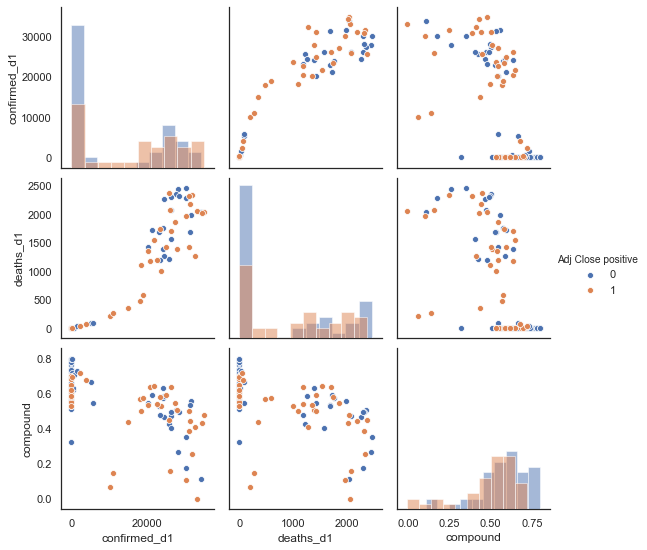

In [19]:
subset = df_merged[['Adj Close positive', 'confirmed_d1', 'deaths_d1', 'compound']]
sns.pairplot(subset, hue="Adj Close positive", diag_kind="hist", diag_kws = dict(alpha=.5) );

Based on the this pairplot, it is hard to find clear, visually distinctive linear (!) separations between the 2 classes. Nevertheless, the histogram shows a shift in the compound score.

**numeric covariates `X_num`**

Sample size of data set: 89






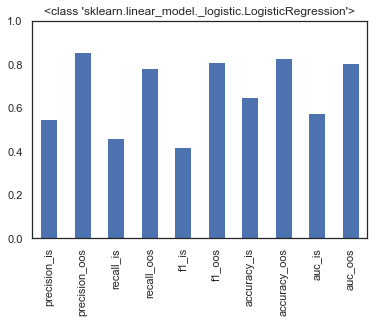

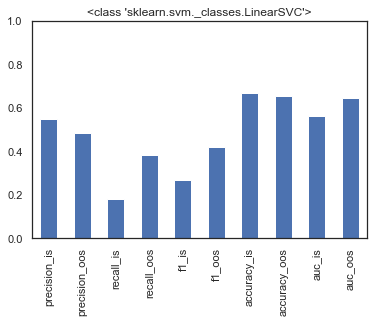

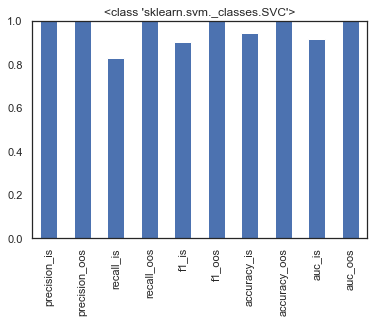

In [20]:
# numeric covariates
sample = df_merged[['Adj Close positive', 'confirmed', 'deaths', 'confirmed_d1', 'deaths_d1', 'confirmed_d2', 'deaths_d2']]
sample_dropna = sample.dropna(axis=0)

X_num = sample_dropna[['confirmed', 'deaths', 'confirmed_d1', 'deaths_d1', 'confirmed_d2', 'deaths_d2']]
X = X_num.values

# y 
y_full = sample_dropna['Adj Close positive']
y = y_full.values

print("Sample size of data set: {}\n".format(len(y)))
# -----------------------------------------------------------------

# 1) Logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
ts_crossval_classification(model)

# 2) Linear SVC
from sklearn.svm import LinearSVC
model = LinearSVC()
ts_crossval_classification(model)

# 3) Kernel SVC
from sklearn.svm import SVC
model = SVC(kernel='rbf', gamma=20)
ts_crossval_classification(model)

Kernel-based SVC clearly wins!

**Step 6: Dimension reduction** [week 6]
- Use one of the dimension reductions methods to dimension-reduce the features
    - PCA or topic model (LDA or STM) or k-means clustering on the featurized text `X_doc`
- Run another classifier

In [21]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

In [22]:
# apply mean-stdv scaling
X = df_merged.drop('Adj Close positive', axis=1)
X_scaled = pd.DataFrame(scale(X.values), index=X.index, columns=X.columns)

# Fit the PCA model and transform X to get the principal components
components = 2
pca = PCA(n_components=components) 
df_pca = pd.DataFrame(data = pca.fit_transform(X), 
                      columns = ['PC{}'.format(i+1) for i in range(components)], 
                      index = X.index)
pca.explained_variance_ratio_

array([0.9371959, 0.0627864])

Two principal components suffice to explain ~ 99% of the variance of the covariates.

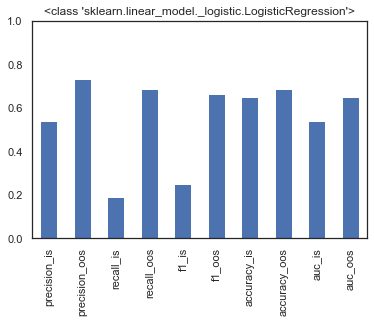

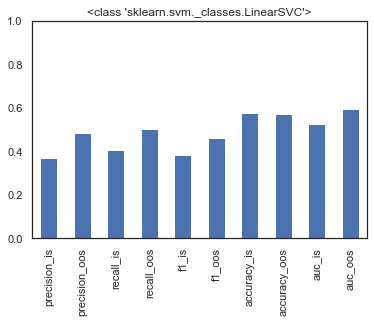

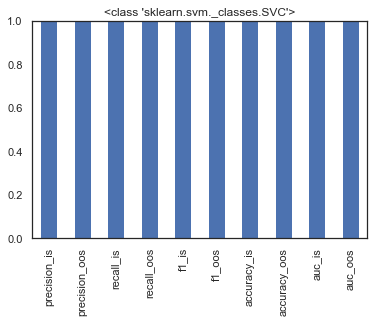

In [23]:
X = df_pca.values
y = y_full.values

# ------------------------------------------------------------------

# 1) Logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
ts_crossval_classification(model)

# 2) Linear SVC
from sklearn.svm import LinearSVC
model = LinearSVC()
ts_crossval_classification(model)

# 3) Kernel SVC
from sklearn.svm import SVC
model = SVC(kernel='rbf', gamma=20)
ts_crossval_classification(model)

Classification performance does decrease somewhat for the Logistic Regression and Linear SVC. The performance of kernel-based SVC even increases, possibly due to the reduction of noise.

**Step bonus: Econometric identification** [week 8]
- Find an exogenous shock affecting this firm (but not all the firms) and a control group of firms not affected
    - example: a natural disaster/shock to the exchange rate/change in ownership... affects the functionning of this firm but not the other firms of the stock market index.  
- scale up the previous data collection to the firms in the control group
- use one of the technique studied in class to causally identify the impact of the exogenous shock on the stock market of the affected firm

Unfortunately, I didn't have time for the bonus exercise.